In [2]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt

from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Reshape, Flatten, Activation
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop

from keras.datasets import mnist
K.set_image_data_format('channels_first')

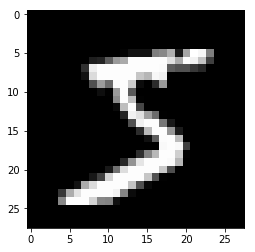

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train /= 255
X_test /= 255
plt.imshow(X_train[0], 'gray')
plt.show()

In [4]:
X_train = X_train.reshape((-1,1,28,28))
X_test = X_test.reshape((-1,1,28,28))

In [10]:
def generator_model(input_shape, train=True):
    inputs = Input(shape=(input_shape,))
    model = Dense(units=128*7*7)(inputs)
    model = Reshape((128, 7, 7), input_shape=(128*7*7,))(model)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)

    model = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(model)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)
    model = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')(model)
    model = Activation('sigmoid')(model)
    
    return Model(inputs=inputs, outputs=model)

def discriminator_model(channels, n_rows, n_cols, train=True):
    inputs = Input(shape=(channels, n_rows, n_cols))
    model = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)
    model = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(model)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)
    model = Flatten()(model)
    model = Dense(1)(model)
    
    return Model(inputs=inputs, outputs=model)

In [11]:
# Train models
g = generator_model(100, train=True)
g.summary()
d = discriminator_model(1,28,28, train=True)
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 7, 7)         28        
_________________________________________________________________
activation_11 (Activation)   (None, 128, 7, 7)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 14, 14)        204864    
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 14, 14)        56        
__________

In [12]:
lr = 1e-4

d_clip_updates = [K.update(v, K.clip(v, -0.01, 0.01)) for v in d.trainable_weights]
d_clip = K.function([],[], d_clip_updates)

X_g = Input(shape=(100,))
X_d = Input(shape=(1, 28, 28))

d_real = d(X_d)
d_fake = d(g(X_g))

loss_d = K.mean(d_fake) - K.mean(d_real)
loss_g = -K.mean(d_fake)

opt_d = RMSprop(lr=lr).get_updates(loss=loss_d, params=d.trainable_weights, constraints=[])
train_d = K.function([X_d, X_g], [loss_d], opt_d)
opt_g = RMSprop(lr=lr).get_updates(loss=loss_g, params=g.trainable_weights, constraints=[])
train_g = K.function([X_g], [loss_g], opt_g)

In [13]:
ind = 0
def next_batch(b):
    global X_train, ind
    ind+=b
    if ind>=X_train.shape[0]:
        ind = 0
        np.random.shuffle(X_train)
        return next_batch(X_train)
    return X_train[ind-b:ind]

In [13]:
#Train
batch_size = 64
epochs = 1

g_losses = []
d_losses = []
g_iter = 0
d_iter = 5
for ep in range(epochs):
    for l in range(X_train.shape[0]//batch_size):
#         if (l+1)%100==0:
#             print(l)
        noise_input = np.random.rand(batch_size, 100)
#         start = l * batch_size
#         end = (l + 1) * batch_size
        d_iter = 100 if g_iter < 25 else 5
        for _ in range(d_iter):
            d_clip([])
            dLoss = train_d([next_batch(batch_size), noise_input])
            
        noise_input = np.random.rand(batch_size, 100)
        gLoss = train_g([noise_input])
        g_iter += 1
        
        g_losses += [gLoss]
        d_losses += [dLoss]

99
199
299
399
499
599


KeyboardInterrupt: 

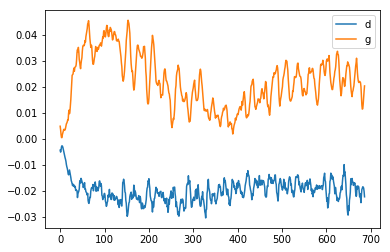

In [14]:
plt.plot(d_losses, label='d')
plt.plot(g_losses, label='g')
plt.legend()
plt.show()

In [14]:
fixed_noise_input = np.random.rand(20, 100)

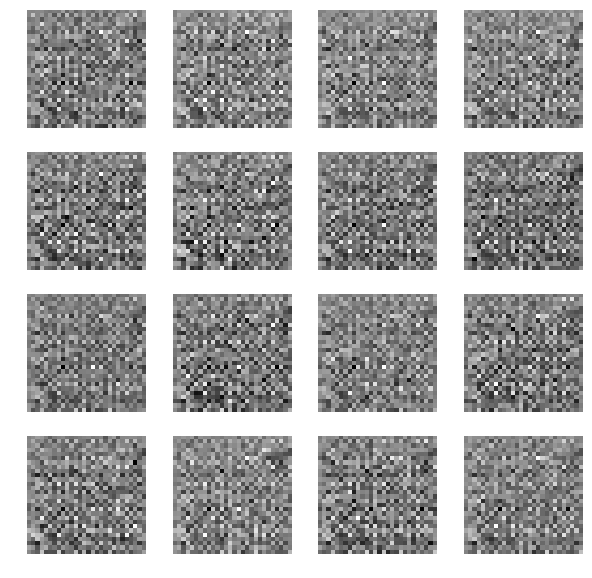

In [17]:
fake_images = g.predict(fixed_noise_input)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake_images[i, 0, :, :], cmap='gray')
    plt.axis('off')
plt.show()